# Imports

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions
DrawingOptions.bondLineWidth=1.8
from rdkit.Chem.EnumerateStereoisomers import EnumerateStereoisomers, StereoEnumerationOptions

import pandas as pd
import re
import os
import requests
from bs4 import BeautifulSoup
from time import sleep
from tqdm import tqdm
import concurrent.futures
from time import sleep

# Import Search Results

In [2]:
csv_file = 'type5.csv'

compounds_inp = pd.read_csv(csv_file)

#generated a reproducible (within this notebook) SMILES string to use later
compounds_inp['Mol Object'] = [Chem.MolFromSmiles(i) for i in compounds_inp['smiles'].tolist()]
compounds_inp['isoSMILES'] = [Chem.MolToSmiles(i, isomericSmiles=True) for i in compounds_inp['Mol Object'].tolist()]
compounds_inp.set_index(compounds_inp['isoSMILES'], inplace = True)

#make list much smaller for testing later
#compounds_inp = compounds_inp.iloc[0:5000, :]

compounds_smiles_dict = {'master':compounds_inp['smiles'].tolist()}
print(f'''Imported {len(compounds_smiles_dict['master'])} structures from {csv_file}''')
compounds_inp

Imported 5787 structures from type5.csv


,smiles,zinc_id,inchikey,mwt,logp,reactive,purchasable,tranche_name,features,Mol Object,isoSMILES
isoSMILES,,,,,,,,,,,
CCc1cccc(N(C#N)CCOCCO)c1,CCc1cccc(N(C#N)CCOCCO)c1,83825615,XYFBVPCYIHKEHI-UHFFFAOYSA-N,234.299,1.545,0,50,BDAA,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001ED7BC...,CCc1cccc(N(C#N)CCOCCO)c1
CCCN(CCC)c1ncnc2[nH]cnc12,CCCN(CCC)c1ncnc2[nH]cnc12,13113759,ZUASHJRECBALLE-UHFFFAOYSA-N,219.292,1.979,0,50,BDAA,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001ED7BC...,CCCN(CCC)c1ncnc2[nH]cnc12
C[C@H](O)CN(C[C@@H](C)O)c1ccccc1,C[C@H](O)CN(C[C@@H](C)O)c1ccccc1,16576421,FKOMNQCOHKHUCP-PHIMTYICSA-N,209.289,1.255,0,50,BDAA,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001ED7BC...,C[C@H](O)CN(C[C@@H](C)O)c1ccccc1
CC(C)CN(c1ncnc2c1cnn2C)C1CC1,CC(C)CN(c1ncnc2c1cnn2C)C1CC1,32926964,JGVSMDJCTFKRKK-UHFFFAOYSA-N,245.330,1.988,0,50,BDAA,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001ED7BC...,CC(C)CN(c1ncnc2c1cnn2C)C1CC1
CCCN(CCC)c1ncnc2c1cnn2C,CCCN(CCC)c1ncnc2c1cnn2C,9531846,VVYVZUXBMFJEKI-UHFFFAOYSA-N,233.319,1.990,0,50,BDAA,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001ED7BC...,CCCN(CCC)c1ncnc2c1cnn2C
...,...,...,...,...,...,...,...,...,...,...,...
Cc1cc(N(CCC#N)CCC#N)ccc1C[C@H]1N=C(c2ccccc2)OC1=O,Cc1cc(N(CCC#N)CCC#N)ccc1C[C@H]1N=C(c2ccccc2)OC1=O,5552639,CAXCBLIMJGHOFX-OAQYLSRUSA-N,386.455,3.543,30,40,GHEB,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001ED7CD...,Cc1cc(N(CCC#N)CCC#N)ccc1C[C@H]1N=C(c2ccccc2)OC1=O
COC(=O)CN(CC(=O)OC)c1ccc(N(CC(=O)OC)CC(=O)OC)cc1,COC(=O)CN(CC(=O)OC)c1ccc(N(CC(=O)OC)CC(=O)OC)cc1,5400230,UEPUBPZLTDXJLB-UHFFFAOYSA-N,396.396,-0.009,0,40,GBAB,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001ED7CD...,COC(=O)CN(CC(=O)OC)c1ccc(N(CC(=O)OC)CC(=O)OC)cc1
Cn1c(=O)[nH]c(=O)c2c1nc(N(CCO)CCO)n2Cc1ccc(F)cc1,Cn1c(=O)[nH]c(=O)c2c1nc(N(CCO)CCO)n2Cc1ccc(F)cc1,917029,LEMYTHUVNQQAFF-UHFFFAOYSA-N,377.376,-0.598,0,40,GBAB,NaN,<rdkit.Chem.rdchem.Mol object at 0x000001ED7CD...,Cn1c(=O)[nH]c(=O)c2c1nc(N(CCO)CCO)n2Cc1ccc(F)cc1


# Simple Filtering (by SMILES strings)

In [3]:
compounds_filtered = compounds_smiles_dict['master']
startlen = len(compounds_filtered)
#compounds_filtered = [x for x in compounds_filtered if '@' not in x] #remove chiral compounds
#print(f'{startlen - len(compounds_filtered)} chiral compounds removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if 'P' not in x] #remove phosphoric acids
print(f'{startlen - len(compounds_filtered)} phosphoric acids removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if 'B1O' not in x] #remove boronic esters
print(f'{startlen - len(compounds_filtered)} boronic esters removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if 'Si' not in x] #remove silicone containing compounds
print(f'{startlen - len(compounds_filtered)} silicone containing compounds removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if '''OB(O)''' not in x] #remove boronic acids
print(f'{startlen - len(compounds_filtered)} boronic acids removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if '''C(O)=O''' not in x] #remove carboxylic acids
compounds_filtered = [x for x in compounds_filtered if '''O=C(O)''' not in x]
print(f'{startlen - len(compounds_filtered)} carboxylic acids removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if '''[2H]''' not in x] #remove deuterium
print(f'{startlen - len(compounds_filtered)} deuterium containing compounds removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if '''[13C]''' not in x] #remove 13C
print(f'{startlen - len(compounds_filtered)} 13C containing compounds removed.'); startlen = len(compounds_filtered)
compounds_filtered = [x for x in compounds_filtered if '''[15N]''' not in x] #remove 15N
print(f'{startlen - len(compounds_filtered)} 15N containing compounds removed.'); startlen = len(compounds_filtered)
print(f'{len(compounds_filtered)} compounds remaining.')

compounds_smiles_dict['simple_filtered'] = compounds_filtered
compounds_smiles_dict['filtered'] = compounds_filtered
compounds_mol_dict = {'master':[Chem.MolFromSmiles(i) for i in compounds_smiles_dict['master']]}
compounds_mol_dict['simple_filtered'] = [Chem.MolFromSmiles(i) for i in compounds_smiles_dict['simple_filtered']]
compounds_mol_dict['filtered'] = [Chem.MolFromSmiles(i) for i in compounds_smiles_dict['simple_filtered']]
#print(compounds_smiles_dict.keys())
#print(compounds_mol_dict.keys())

1 phosphoric acids removed.
0 boronic esters removed.
1 silicone containing compounds removed.
0 boronic acids removed.
113 carboxylic acids removed.
0 deuterium containing compounds removed.
0 13C containing compounds removed.
0 15N containing compounds removed.
5672 compounds remaining.


# Advanced Functional Group Filtering (RDKit, SMARTS)

## Definitions (run this cell before filtering)

In [4]:
def find_azides(inp_mols): #find molecules containing azides
    azide = Chem.MolFromSmarts('[$(*-[NX2-]-[NX2+]#[NX1]),$(*-[NX2]=[NX2+]=[NX1-])]')
    azide_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(azide):
            azide_mols.append(m)
    print(f'Found {len(azide_mols)} compounds containing at least 1 azide')
    return(azide_mols)

def find_phenols(inp_mols): #find molecules containing phenols
    phenol = Chem.MolFromSmarts('[OH]c')
    phenol_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(phenol):
            phenol_mols.append(m)
    print(f'Found {len(phenol_mols)} compounds containing at least 1 phenol.')
    return(phenol_mols)

def find_multipleamines(inp_mols): #find molecules containing multiple amines (primary/secondary/tertiary)
    amines = Chem.MolFromSmarts('[NX3!$(NC=O);!$(NC=S);!$(NC#N)]')
    multipleamines_mols = []
    for m in inp_mols:
        num_amines = m.GetSubstructMatches(amines)
        if len(num_amines) > 1:
            multipleamines_mols.append(m)
    print(f'Found {len(multipleamines_mols)} compounds with multiple amines.')
    return(multipleamines_mols)

def find_amineandamides(inp_mols):
    amine = Chem.MolFromSmarts('[NX3!$(NC=O);!$(NC=S);!$(NC#N)]')
    amide = Chem.MolFromSmarts('[NX3][CX3](=[OX1])[#6]')
    amineandamide_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(amine) and m.HasSubstructMatch(amide):
            amineandamide_mols.append(m)
    print(f'Found {len(amineandamide_mols)} compounds with at least 1 amine and 1 amide.')
    return(amineandamide_mols)

def find_arylhalides(inp_mols): #does not include F, uncomment below to include arly fluorides
    arylhalide = Chem.MolFromSmarts('[Cl,Br,I]c1ccccc1')
    #arylhalide = Chem.MolFromSmarts('[F,Cl,Br,I]c1ccccc1')
    arylhalide_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(arylhalide):
            arylhalide_mols.append(m)
    print(f'Found {len(arylhalide_mols)} compounds with at least 1 aryl halide (not including F).')
    return(arylhalide_mols)

def find_alkylhalides(inp_mols):
    alkylhalide = Chem.MolFromSmarts('[F,Cl,Br,I]C')
    alkylhalide_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(alkylhalide):
            alkylhalide_mols.append(m)
    print(f'Found {len(alkylhalide_mols)} compounds with at least 1 alykl halide.')
    return(alkylhalide_mols)

def find_nitros(inp_mols): #hits both forms
    nitro = Chem.MolFromSmarts('[$([NX3](=O)=O),$([NX3+](=O)[O-])][!#8]')
    
def find_noxides(inp_mols): #won't hit azoxy, nitro, nitroso, or nitrate
    noxide = Chem.MolFromSmarts('[$([#7+][OX1-]),$([#7v5]=[OX1]);!$([#7](~[O])~[O]);!$([#7]=[#7])]')
    
def find_nitrosos(inp_mols):
    nitroso = Chem.MolFromSmarts('[NX2]=[OX1]')
    
def find_hydrazinse(inp_mols):
    hydrazine = Chem.MolFromSmarts('[NX3][NX3]')
    
def find_hydrazones(inp_mols):
    hydrazone = Chem.MolFromSmarts('[NX3][NX2]=[*]')
    
def find_aldehydes(inp_mols):
    aldehyde = Chem.MolFromSmarts('[CX3H1](=O)[#6]')
    aldehyde_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(aldehyde):
            aldehyde_mols.append(m)
    print(f'Found {len(aldehyde_mols)} compounds with at least 1 aldehyde.')
    return(aldehyde_mols)
    
def find_oximes(inp_mols): #hits aldoximes and ketoximes
    oxime = Chem.MolFromSmarts('[CX3]=[NX2][OH]')
    oxime_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(oxime):
            oxime_mols.append(m)
    print(f'Found {len(oxime_mols)} compounds with at least 1 oxime.')    
    return(oxime_mols)

def find_sulferacids(inp_mols):
    sulfonicacid = Chem.MolFromSmarts('[$([#16X4](=[OX1])(=[OX1])([#6])[OX2H,OX1H0-]),$([#16X4+2]([OX1-])([OX1-])([#6])[OX2H,OX1H0-])]')
    sulfinicacid = Chem.MolFromSmarts('[$([#16X3](=[OX1])[OX2H,OX1H0-]),$([#16X3+]([OX1-])[OX2H,OX1H0-])]')
    sulfamicacid = Chem.MolFromSmarts('[$([#16X4]([NX3])(=[OX1])(=[OX1])[OX2H,OX1H0-]),$([#16X4+2]([NX3])([OX1-])([OX1-])[OX2H,OX1H0-])]')
    sulfenicacid = Chem.MolFromSmarts('[#16X2][OX2H,OX1H0-]')
    sulferacid_mols = []
    for m in inp_mols:
        if  m.HasSubstructMatch(sulfonicacid) or m.HasSubstructMatch(sulfinicacid) or m.HasSubstructMatch(sulfamicacid) or m.HasSubstructMatch(sulfenicacid):
            sulferacid_mols.append(m)
    print(f'Found {len(sulferacid_mols)} compounds with at least 1 acidic sulfer moiety.')
    return(sulferacid_mols)

def find_alkanols(inp_mols):
    alkanol = Chem.MolFromSmarts('[OH]C')
    alkanol_mols = []
    for m in inp_mols:
        if m.HasSubstructMatch(alkanol):
            alkanol_mols.append(m)
    print(f'Found {len(alkanol_mols)} compounds containing at least 1 alkanol.')
    return(alkanol_mols)
    

## Filtering

In [5]:
#Functional Groups to Filter, comment lines you do not wish to exclude
to_filter = [
    'azides',
    'phenols',
    'multipleamines',
    'arylhalides',
    'aldehydes',
    'oximes',
    'sulferacids',
    'amineandamides',
    'alkylhalides',
    'alkanols'
]

#imports structures in case simple filtering has not been used
try: startlen = len(compounds_mol_dict['filtered'])
except: 
    compounds_mol_dict['filtered'] = [Chem.MolFromSmiles(i) for i in compounds_smiles_dict['master']]
    compounds_smiles_dict['filtered'] = compounds_smiles_dict['master']
    
#generate dictionary of functional groups
compounds_mol_dict['azides'] = find_azides(compounds_mol_dict['filtered'])
compounds_mol_dict['phenols'] = find_phenols(compounds_mol_dict['filtered'])
compounds_mol_dict['multipleamines'] = find_multipleamines(compounds_mol_dict['filtered'])
compounds_mol_dict['arylhalides'] = find_arylhalides(compounds_mol_dict['filtered'])
compounds_mol_dict['alkylhalides'] = find_alkylhalides(compounds_mol_dict['filtered'])
compounds_mol_dict['aldehydes'] = find_aldehydes(compounds_mol_dict['filtered'])
compounds_mol_dict['oximes'] = find_oximes(compounds_mol_dict['filtered'])
compounds_mol_dict['sulferacids'] = find_sulferacids(compounds_mol_dict['filtered'])
compounds_mol_dict['amineandamides'] = find_amineandamides(compounds_mol_dict['filtered'])
compounds_mol_dict['alkanols'] = find_alkanols(compounds_mol_dict['filtered'])

#filter based on selected functional groups
start_len = len(compounds_mol_dict['filtered'])

for fg in tqdm(to_filter):
    compounds_mol_dict['filtered'] = [m for m in compounds_mol_dict['filtered'] if m not in compounds_mol_dict[fg]]
            
end_len = len(compounds_mol_dict['filtered'])

print(f'\n{start_len - end_len} compounds removed according to selected filters.')
print(f'{end_len} compounds remaining in current results.')
    

#print(compounds_mol_dict.keys())

Found 0 compounds containing at least 1 azide
Found 155 compounds containing at least 1 phenol.
Found 1375 compounds with multiple amines.
Found 458 compounds with at least 1 aryl halide (not including F).
Found 296 compounds with at least 1 alykl halide.
Found 24 compounds with at least 1 aldehyde.
Found 18 compounds with at least 1 oxime.
Found 5 compounds with at least 1 acidic sulfer moiety.
Found 1337 compounds with at least 1 amine and 1 amide.
Found 2152 compounds containing at least 1 alkanol.


100%|██████████| 10/10 [00:00<00:00, 68.78it/s]


4287 compounds removed according to selected filters.
1385 compounds remaining in current results.


## Preview Results (optional)

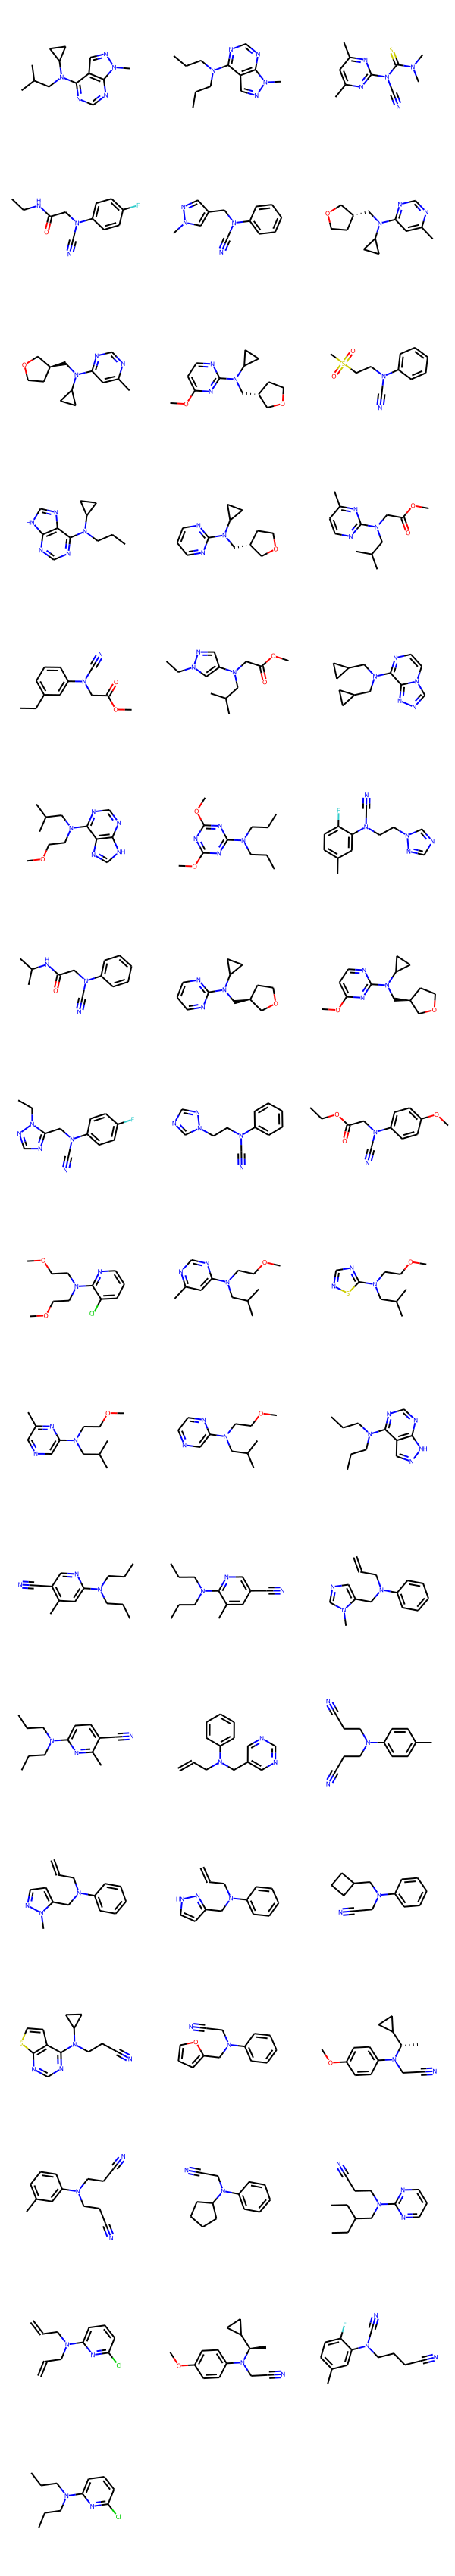

In [6]:
#print the first 50
template = Chem.MolFromSmiles('C1(NC2=CC=CC=C2)=CC=CC=C1')
AllChem.Compute2DCoords(template)
ms = compounds_mol_dict['filtered'][1:50]
Draw.MolsToGridImage(ms)

## Organize Results

In [7]:
#place data in dataframe along with accompanying ZINCID
filtered_df = pd.DataFrame
filtered_smiles_list = [Chem.MolToSmiles(m, isomericSmiles=True) for m in compounds_mol_dict['filtered']]
filtered_df = pd.DataFrame()
filtered_df['smiles'] = filtered_smiles_list
filtered_zincid_list = []
for m in filtered_df['smiles'].tolist():
    filtered_zincid_list.append(compounds_inp.loc[m]['zinc_id'])
filtered_df['zinc_id'] = filtered_zincid_list
filtered_df


,smiles,zinc_id
0,CCCN(CCC)c1ncnc2[nH]cnc12,13113759
1,CC(C)CN(c1ncnc2c1cnn2C)C1CC1,32926964
2,CCCN(CCC)c1ncnc2c1cnn2C,9531846
3,Cc1cc(C)nc(N(C#N)C(=S)N(C)C)n1,380942
4,CCNC(=O)CN(C#N)c1ccc(F)cc1,253433408
...,...,...
1380,C=CCN(CC=C)c1ccc(-c2nc(-c3cccc(OC)c3OC)no2)cn1,12713429
1381,CCCCN(CCCC)c1nc2ccccc2nc1[C@@H](C#N)C(=O)OCCOC,4950114
1382,CCCCN(CCCC)c1nc2ccccc2nc1[C@H](C#N)C(=O)OCCOC,4950119
1383,Cc1cc(N(CCC#N)CCC#N)ccc1C[C@@H]1N=C(c2ccccc2)O...,1626596


# Search Commercial Availability

## Definitions

In [8]:
#To add new vendors: you must add information in the 3 places below: name, url_pattern, and cat_pattern
#nothing else needs changing

#list of vendors as they would appear on a ZINC substance page
vendors = {}
vendors['names'] = [
    'Combi-Blocks',
    'Matrix Scientific',
    'AK Scientific',
    'Enamine', #building blocks only, no make-on-demand
    'AstaTech',
    'Sigma Aldrich',
    'Alfa Aesar',
    'AmBeed',
    #'Acros',
    'aaBlocks',
    'AChemBlock',
    'ChemImpex',
    'BioSynth' #same as carbosynth
]

vendors['url_patterns'] = []
#regex expressions for URL capture, must be in same order as vendor list above
combi_blocks_url_pattern = re.compile('https?:\/\/(?:www\.)?combi-blocks\.com\/\S*'); vendors['url_patterns'].append(combi_blocks_url_pattern)
matrix_scientific_url_pattern = re.compile('https?:\/\/(?:www\.)?matrixscientific\.com\/\S*'); vendors['url_patterns'].append(matrix_scientific_url_pattern)
ak_scientific_url_pattern = re.compile('http[s]?:\/\/[www\.]?aksci\.com\/\S*'); vendors['url_patterns'].append(ak_scientific_url_pattern)
enamine_url_pattern = re.compile('https?:\/\/(?:www\.)?enaminestore\.com\/.*(?:\/EN)\S*'); vendors['url_patterns'].append(enamine_url_pattern)
astatech_url_pattern = re.compile('https?:\/\/(?:www\.)?astatechinc\.com\/\S*'); vendors['url_patterns'].append(astatech_url_pattern)
sigma_aldrich_url_pattern = re.compile('https?:\/\/(?:www\.)?sigmaaldrich\.com\/catalog\/search\?term=\w+[^|]+\w+'); vendors['url_patterns'].append(sigma_aldrich_url_pattern)
alfa_aesar_url_pattern = re.compile('https?:\/\/(?:www\.)?alfa\.com\S*'); vendors['url_patterns'].append(alfa_aesar_url_pattern)
ambeed_url_pattern = re.compile('https?:\/\/(?:www\.)?ambeed\.com\/\S*'); vendors['url_patterns'].append(ambeed_url_pattern)
#acros_url_pattern = re.compile(''); vendors['url_patterns'].append(acros_url_pattern)
aablocks_url_pattern = re.compile('https?:\/\/(?:www\.)?aablocks\.com\/\S*'); vendors['url_patterns'].append(aablocks_url_pattern)
achemblock_url_pattern = re.compile('https?:\/\/(?:www\.)?achemblock\.com\/\S*'); vendors['url_patterns'].append(achemblock_url_pattern)
chemimpex_url_pattern = re.compile('https?:\/\/(?:www\.)?chemimpex\.com\/\S*'); vendors['url_patterns'].append(chemimpex_url_pattern)
biosynth_url_pattern = re.compile('https?:\/\/(?:www\.)?biosynth\.com\/\S*'); vendors['url_patterns'].append(biosynth_url_pattern)

vendors['cat_patterns'] = []
#regex expressions for catalog #s pulled from the URL matches, must be in same order as everything above, all catalog numbers are returned in group1 of the re search
combi_blocks_cat_pattern = re.compile('(?:\/cgi-bin\/find\.cgi\?)(\w+[^\w]{1}\w+)'); vendors['cat_patterns'].append(combi_blocks_cat_pattern)
matrix_scientific_cat_pattern = re.compile('matrixscientific\.com\/(\w+)\.html'); vendors['cat_patterns'].append(matrix_scientific_cat_pattern)
ak_scientific_cat_pattern = re.compile('cat=(\w*)'); vendors['cat_patterns'].append(ak_scientific_cat_pattern)
enamine_cat_pattern = re.compile('catalog\/(EN\w+-\w+)'); vendors['cat_patterns'].append(enamine_cat_pattern)
astatech_cat_pattern = re.compile('CRNO=(\w*)'); vendors['cat_patterns'].append(astatech_cat_pattern) #this isnt actual catalog number, just URL number?
sigma_aldrich_cat_pattern = re.compile('(?:catalog\/search\?term=)(\w+)\W'); vendors['cat_patterns'].append(sigma_aldrich_cat_pattern)
alfa_aesar_cat_pattern = re.compile('catalog\/(\w*)'); vendors['cat_patterns'].append(alfa_aesar_cat_pattern)
ambeed_cat_pattern = re.compile('keyword=(\w*)'); vendors['cat_patterns'].append(ambeed_cat_pattern)
#acros_cat_pattern = re.compile(''); vendors['cat_patterns'].append(acros_cat_pattern)
aablocks_cat_pattern = re.compile('id=(\w*)'); vendors['cat_patterns'].append(aablocks_cat_pattern)
achemblock_cat_pattern = re.compile('q=(\w*)'); vendors['cat_patterns'].append(achemblock_cat_pattern)
chemimpex_cat_pattern = re.compile('search=(\w*)'); vendors['cat_patterns'].append(chemimpex_cat_pattern)
biosynth_cat_pattern = re.compile('(?<!\/en\/)products\/([\w,-]*)'); vendors['cat_patterns'].append(biosynth_cat_pattern)

## ZINC Web Scraping

In [9]:
#NOTE: This is a web scrapper with multithreading, will use a lot of internet bandwidth and your CPU will be rippin
#can lower MAX_THREADS to make it less rippin but it will be mad slow

def download_url(url):
    headers = {'user-agent': 'Chrome/101.0.4951.41'} #necessary for aldrich website
    r = requests.get(url, headers=headers)
    #r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html')
    return soup

def fix_urls(url): #fixes URLs from outdated formats on ZINC's website e.g. for Matrix zinc lists HTTP but now must use HTTPS
    if 'matrixscientific' in url: #matrix needs https or the link will just take you to the home page
        url = url.replace('http','https')
    if 'aldrich' in url: #aldrich basically needs complete reformatting
        sigma_aldrich_cat_pattern = re.compile('(?:catalog\/search\?term=)(\w+)\W') #redefine in case the order changes in the list above
        cat = re.search(sigma_aldrich_cat_pattern,url).group(1)
        url = f'https://www.sigmaaldrich.com/US/en/product/aldrich/{cat}'
    if 'astatechinc' in url:
        pass #this one is rough, the catalog number format isnt consistant and getting stock information requires actually querying the website  
    if 'aablocks' in url: #basically needs complete reformatting
        aablocks_cat_pattern = re.compile('id=(\w*)')
        cat = re.search(aablocks_cat_pattern,url).group(1)
        url = f'https://www.aablocks.com/prod/{cat}'
    return url

def get_commercial_data(zincid):
    url = f'https://zinc.docking.org/substances/{zincid}/'
    soup = download_url(url)
    
    url_list = []
    for tag in soup.find_all('a'):
        url_list.append(tag.get('href'))
    
    commercial_data_id = []
    for i in range(len(vendors['names'])):
        matches = [x for x in url_list if re.search(vendors['url_patterns'][i], x)]
        if len(matches) != 0:
            target_url = matches[0]
            target_cat = re.search(vendors['cat_patterns'][i],target_url).group(1)
            target_url = fix_urls(target_url) #see above function, this is fixed after extracting catalog number because the ZINC url format is more consistant
            target_tup = target_url,target_cat
            commercial_data_id.append(target_tup)
        else:
            commercial_data_id.append(('',''))  
    return(commercial_data_id)

#using intervaled scraping keeps the URL pool small, prevents disconnection
print('Scraping ZINC Substance Pages...')
zincid_list = filtered_df['zinc_id'].tolist()
interval_len = 100
commercial_data = []
for interval in tqdm(range(int(len(zincid_list) / interval_len) + (len(zincid_list) % interval_len > 0))):
    zincid_list_interval_start = interval * interval_len
    zincid_list_interval_end = interval_len * (interval + 1)
    try:
        zincid_list_interval = zincid_list[zincid_list_interval_start:zincid_list_interval_end]
    except:
        zincid_list_interval = zincid_list[zincid_list_interval_start:]
    while True: #watchdog loop for making sure disconnections don't cause exceptions, retries interval instead
        try:
            with concurrent.futures.ThreadPoolExecutor() as executor:
                commercial_data_results = executor.map(get_commercial_data,zincid_list_interval)
                commercial_data_interval = [result for result in commercial_data_results]
                commercial_data += commercial_data_interval
            break
        except Exception:
            print('Disconnected: Retrying block of URLs.')
            continue
    sleep(0.5) #idk feels like there should be time between intervals
    
commercial_data = list(map(list, zip(*commercial_data))) #transpose the list of lists

for k in range(len(vendors['names'])):
    link_list = []
    for link_location,link_name in  commercial_data[k]:
        if link_location == '' and link_name == '':
            link_list.append('')
        else:
            link_list.append(f'''=HYPERLINK("{link_location}","{link_name}")''')

    filtered_df[vendors['names'][k]] = link_list

Scraping ZINC Substance Pages...


100%|██████████| 14/14 [02:30<00:00, 10.72s/it]


## Crude Validation of Stock / Vendor Web Scraping (optional)
This is a separate web scrapping opperation that visits the vendor sites and determines if its actually in stock or not, if not in stock it will be removed from the results.

In [10]:
#Setup of dynamic javascript scraping tools:

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

chrome_driver_path = ChromeDriverManager().install()

def download_url(url): #redefine because why not
    headers = {'user-agent': 'Chrome/101.0.4951.41'} #necessary for aldrich website
    r = requests.get(url, headers=headers)
    soup = BeautifulSoup(r.content, 'html')
    return soup

def download_dynamic_url(url): #some websites like enamine use dynamic javascript rendering and must be downloaded differently
    chrome_driver_service = Service(chrome_driver_path)
    
    chrome_options = Options()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    
    driver = webdriver.Chrome(service_log_path = os.devnull, service = chrome_driver_service, options=chrome_options)
    driver.get(url)
    soup = BeautifulSoup(driver.page_source)
    driver.quit()
    return soup

#these functions visit each vendor website and use a crude criteria to validate if its in stock or not
#prefer downloading within each function for better multithreading performace

def validate_combiblocks(url): #counts the number of 'Enquire's on the page, should only be 1 for in stock products
    soup = download_url(url)
    if soup.get_text().count('Enquire') > 1:
        return False
    else:
        return True
    
def validate_matrix(url): #'In Stock' good positive match (case sensitive)
    soup = download_url(url)
    if 'In Stock' in soup.get_text():
        return True
    else:
        return False

def validate_sigmaaldrich(url): #anything that actaully loads a product seems to be in stock;'PRODUCT NOT FOUND' keyworf for not found
    soup = download_url(url)
    if 'Product Not Found' in soup.get_text():
        return False
    else:
        return True
    
def validate_enamine(url): #this isnt super accurate, at the time of writing, only US Rush is actually available, but should still be helpful
    soup = download_dynamic_url(url)
    if 'In Stock' in soup.get_text():
        return True
    else:
        return False
    
def validate_alfaaesar(url):
    soup = download_url(url)
    if 'cannot be ordered online' in soup.get_text() or 'page not found' in soup.get_text():
        return False
    else:
        return True

def validate_aksci(url):
    soup = download_dynamic_url(url)
    if 'IN STOCK' in soup.get_text():
        return True
    else:
        return False
    
#do the scraping, multithreaded, windows will appear/disappear for downloading dynamic urls
def get_vendor_data(cell_string): #returns blank string if not in stock, otherwise returns url
    if cell_string == '':
        return('')
    else:
        url = cell_string.split('''"''')[1] #strips cell fomula down to URL
    if 'combi-blocks' in url:
        if not validate_combiblocks(url):
            return('')
    if 'matrixscientific' in url:
        if not validate_matrix(url):
            return('')
    if 'sigmaaldrich' in url:
        if not validate_sigmaaldrich(url):
            return('')
    if 'enaminestore' in url:
        if not validate_enamine(url):
            return('')
    if 'alfa.com' in url:
        if not validate_alfaaesar(url):
            return('')
    if 'aksci' in url:
        if not validate_aksci(url):
            return('')
    return(cell_string)

interval_len2 = 100

print('\nScraping Vendor Websites...')
for column in tqdm(filtered_df.columns[2:]):
    
    vendor_data = []
    url_list = filtered_df[column].tolist()
    
    for interval in range(int(len(url_list) / interval_len2) + (len(url_list) % interval_len2 > 0)):
        url_list_interval_start = interval * interval_len2
        url_list_interval_end = interval_len2 * (interval + 1)
        try:
            url_list_interval = url_list[url_list_interval_start:url_list_interval_end]
        except:
            url_list_interval = url_list[url_list_interval_start:]
        count = 0
        while True: #watchdog loop for making sure disconnections don't cause exceptions, retries interval instead
            count += 1
            try:
                with concurrent.futures.ThreadPoolExecutor() as executor:
                    vendor_data_results = executor.map(get_vendor_data,url_list_interval)
                    vendor_data_interval = [result for result in vendor_data_results]
                    vendor_data += vendor_data_interval
                break
            except Exception:
                if count > 5:
                    print('Too many disconnects: sleeping 2 minutes.')
                    sleep(120)
                    count = 0
                    continue
                else:
                    print('Disconnected: Retrying block of URLs.')
                    continue
    
    filtered_df[column] = vendor_data
        



====== WebDriver manager ======
Current google-chrome version is 100.0.4896
Get LATEST chromedriver version for 100.0.4896 google-chrome
Driver [C:\Users\Dave\.wdm\drivers\chromedriver\win32\100.0.4896.60\chromedriver.exe] found in cache



Scraping Vendor Websites...


100%|██████████| 12/12 [02:53<00:00, 14.43s/it]


## Filter Based on Results (optional)

In [11]:
#remove compounds not available from a certain number of vendors
minimum_vendors = 1

rows_to_remove = []
for i in range(len(filtered_df.index)):
    #total number of vendors - number of vendors not available from = number of vendors available from
    if len(filtered_df.iloc[i].values.tolist()[2:]) - filtered_df.iloc[i].values.tolist()[2:].count('') < minimum_vendors:
         rows_to_remove.append(i)
for row in rows_to_remove:
        filtered_df.drop([row], inplace = True)
print(f'Removed {len(rows_to_remove)} compounds not available from specified number of vendors.')

Removed 1356 compounds not available from specified number of vendors.


# Print to File

In [12]:
filtered_df.to_csv(f'{csv_file[:-4]}_filtered.csv', index = False)